In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [12]:
# Transformations
trf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
# Load CIFAR10 dataset
train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=trf)
test_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=trf)

print('the shape of a image : ',train_ds[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified
the shape of a image :  torch.Size([3, 32, 32])


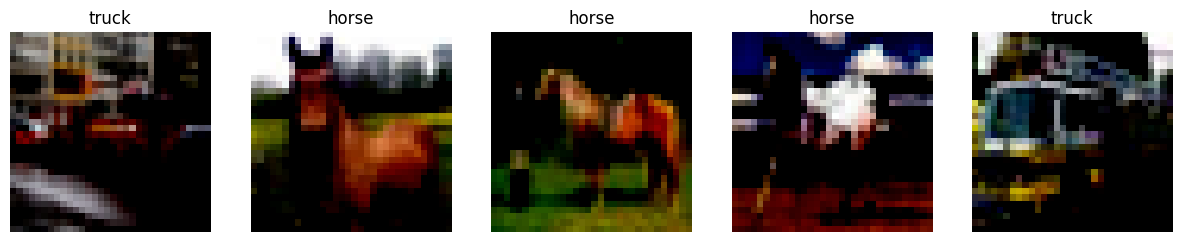

In [14]:
# Define a mapping of labels to class names
class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to display images
def show_images(dataset, num_images=5):
    # Create a DataLoader for the dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)

    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Convert images to a grid
    images = images.numpy().transpose((0, 2, 3, 1))  # Rearrange to (H, W, C)

    # Plot images with their labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(np.clip(images[i], 0, 1))  # Clip to valid image range
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.show()

# Show images from the training dataset
show_images(train_ds)


In [15]:
# Limit the number of images (e.g., first 5000 images for training and 1000 for testing)
#train_subset = Subset(train_ds, indices=list(range(20000)))  # Use the first 5000 images
#test_subset = Subset(test_ds, indices=list(range(4000)))    # Use the first 1000 images

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

In [16]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d((2, 2))

        self.do1 = nn.Dropout(0.5)
        self.do2 = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)

        self.af = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.af(self.bn1(self.conv1(x))))
        x = self.pool2(self.af(self.bn2(self.conv2(x))))
        x = self.do1(self.pool3(self.af(self.bn3(self.conv3(x)))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.af(self.fc1(x))
        x = self.af(self.fc2(x))
        x = self.af(self.fc3(x))
        x = self.fc4(x)
        return x



In [17]:
def train_with_testing(model, train_loader, test_loader, epochs, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        tr_loss = 0
        tr_acc = 0
        total = 0
        correct = 0

        for img, label in train_loader:
            # Zero gradients
            opt.zero_grad()

            # Forward pass
            y_pred = model(img)

            # Compute loss
            loss = loss_fn(y_pred, label)
            tr_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(y_pred, dim=1)
            total += label.shape[0]
            correct += (pred_label == label).sum().item()

            # Backpropagation
            loss.backward()
            # Update weights
            opt.step()

        # Calculate accuracy and average loss for training
        tr_acc = (correct / total) * 100
        avg_train_loss = tr_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        train_acc.append(tr_acc)

        # Testing phase
        model.eval()
        tst_loss = 0
        tst_correct = 0
        tst_total = 0

        with torch.no_grad():
            for img, label in test_loader:
                #forw
                y_pred = model(img)
                #loss
                loss = loss_fn(y_pred, label)
                tst_loss += loss.item()
                #acc
                pred_label = torch.argmax(y_pred, dim=1)
                tst_total += label.shape[0]
                tst_correct += (pred_label == label).sum().item()

        # Calculate accuracy and average loss for testing
        tst_acc = (tst_correct / tst_total) * 100
        avg_test_loss = tst_loss / len(test_loader)
        test_loss.append(avg_test_loss)
        test_acc.append(tst_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {tr_acc:.2f}%, "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {tst_acc:.2f}%")

    return train_loss, train_acc, test_loss, test_acc


In [18]:
import matplotlib.pyplot as plt

def plot_train_test_results(train_loss, train_acc, test_loss, test_acc):
    epochs = range(1, len(train_loss) + 1)

    # Create a figure with subplots for loss and accuracy
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', color='red', marker='x')
    plt.title('Train and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, test_acc, label='Test Accuracy', color='red', marker='x')
    plt.title('Train and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


Epoch 1/10, Train Loss: 1.7759, Train Acc: 33.04%, Test Loss: 1.4323, Test Acc: 46.81%
Epoch 2/10, Train Loss: 1.4312, Train Acc: 47.09%, Test Loss: 1.3197, Test Acc: 51.70%
Epoch 3/10, Train Loss: 1.3254, Train Acc: 51.72%, Test Loss: 1.2089, Test Acc: 55.46%
Epoch 4/10, Train Loss: 1.2444, Train Acc: 55.28%, Test Loss: 1.2336, Test Acc: 56.33%
Epoch 5/10, Train Loss: 1.1853, Train Acc: 57.37%, Test Loss: 1.0676, Test Acc: 62.44%
Epoch 6/10, Train Loss: 1.1387, Train Acc: 59.27%, Test Loss: 1.0370, Test Acc: 62.88%
Epoch 7/10, Train Loss: 1.0999, Train Acc: 60.94%, Test Loss: 0.9799, Test Acc: 66.10%
Epoch 8/10, Train Loss: 1.0705, Train Acc: 61.91%, Test Loss: 0.9704, Test Acc: 65.56%
Epoch 9/10, Train Loss: 1.0390, Train Acc: 63.16%, Test Loss: 1.0012, Test Acc: 64.30%
Epoch 10/10, Train Loss: 1.0195, Train Acc: 63.89%, Test Loss: 0.9106, Test Acc: 68.12%


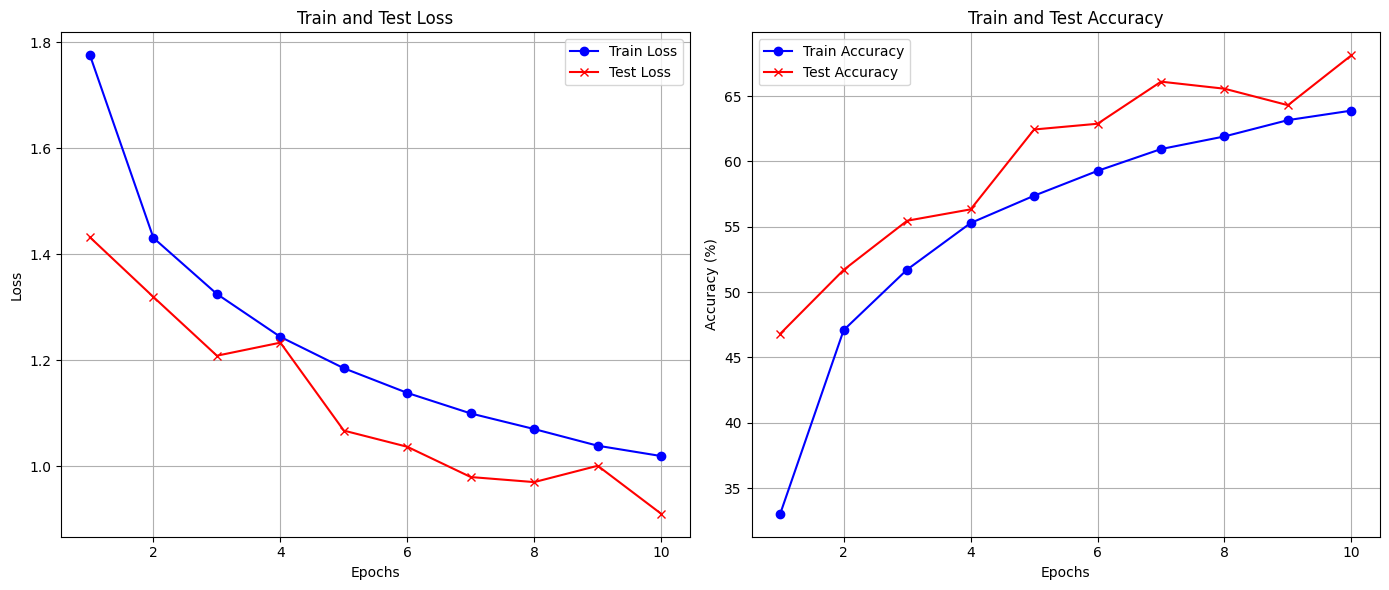

In [19]:
# Initialize model, optimizer, and loss function
model = cnn()
lr = 0.02
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# Train and test the model
epochs = 10
train_loss, train_acc, test_loss, test_acc = train_with_testing(
    model, train_loader, test_loader, epochs, loss_fn, opt
)


# Plot results
plot_train_test_results(train_loss, train_acc, test_loss, test_acc)



In [11]:
opt.zero_grad()